[*********************100%***********************]  4 of 4 completed


Portefeuille optimal selon SHARPE
        Poids optimaux
RY.TO         0.887996
SU.TO         0.030663
ABX.TO        0.081341
Rendement : 15.11%
Risque    : 17.24%
Sharpe    : 0.877
Portefeuille optimal selon Markowitz (Risque Minimum)
        Poids optimaux
RY.TO         0.744627
SU.TO         0.025145
ABX.TO        0.230228
Rendement : 13.66%
Risque    : 16.38%
Portefeuille optimal selon TREYNOR
        Poids optimaux
RY.TO         0.975283
SU.TO         0.006388
ABX.TO        0.018329
Rendement : 15.70%
Risque    : 18.10%
Treynor   : 0.185
Beta      : 0.851


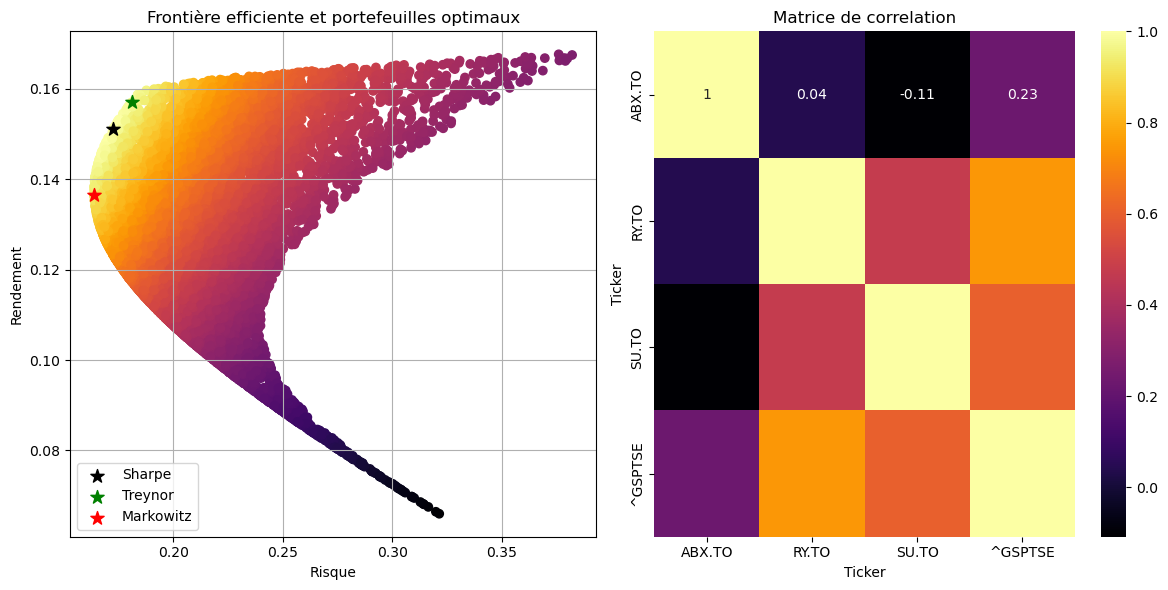

In [18]:
# Bibliothèques
import numpy as np
import yfinance as yf
import seaborn as sns
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Paramètres
debut, fin = '2020-01-01', '2025-01-01'
marche = ["^GSPTSE"]
actifs = ["RY.TO","SU.TO","ABX.TO"]
taux_sans_risque = 0
# Télécharger les prix ajustés (close ajusté)
tickers = actifs + marche
prix = yf.download(tickers, start=debut, end=fin, auto_adjust=True)["Close"]
# Rendements mensuels pour le marche et pour le portefeuille
rendements = prix.resample("M").last().pct_change()
rendements.dropna(inplace=True)
# Espérance, covariance annualisées et correlation
esperance = rendements[actifs].mean() * 12
covariance = rendements[actifs].cov() * 12
correlation = rendements.corr()
# Simulation Monte Carlo
nombrePF = 10000
nombreActifs = len(actifs)
poidsPF = np.zeros((nombrePF, nombreActifs))
rendementPF = np.zeros(nombrePF)
risquePF = np.zeros(nombrePF)
sharpePF = np.zeros(nombrePF)
betaPF = np.zeros(nombrePF)
treynorPF = np.zeros(nombrePF)
for i in range(nombrePF):
    w = np.random.random(nombreActifs)
    w = w/np.sum(w)
    poidsPF[i] = w
    rendementPF[i] = np.dot(w, esperance)
    risquePF[i] = np.sqrt(np.dot(w.T, np.dot(covariance, w)))
    # Ratio de Sharpe
    sharpePF[i] = (rendementPF[i] - taux_sans_risque) / risquePF[i]
    # La régression CAPM pour trouver beta a fin de calculer ratio de Treynor
    excess_PF = rendements[actifs].dot(w) - taux_sans_risque/12 # mensuel
    excess_marche = rendements[marche] - taux_sans_risque/12
    X = sm.add_constant(excess_marche)
    model = sm.OLS(excess_PF, X).fit()
    beta = model.params.iloc[1]
    betaPF[i] = beta
    #Ratio de Treynor
    treynorPF[i] = (rendementPF[i] - taux_sans_risque) / beta if beta != 0 else np.nan
#Index des portefeuilles optimaux
idx_sharpe_max = sharpePF.argmax()
idx_treynor_max = np.nanargmax(treynorPF)
idx_markowitz = risquePF.argmin()

#Affichage des résultats
print("Portefeuille optimal selon SHARPE")
print(pd.DataFrame(poidsPF[idx_sharpe_max], index=actifs, columns=["Poids optimaux"]))
print(f"Rendement : {rendementPF[idx_sharpe_max]:.2%}")
print(f"Risque    : {risquePF[idx_sharpe_max]:.2%}")
print(f"Sharpe    : {sharpePF[idx_sharpe_max]:.3f}")

print("Portefeuille optimal selon Markowitz (Risque Minimum)")
print(pd.DataFrame(poidsPF[idx_markowitz], index=actifs, columns=["Poids optimaux"]))
print(f"Rendement : {rendementPF[idx_markowitz]:.2%}")
print(f"Risque    : {risquePF[idx_markowitz]:.2%}")

print("Portefeuille optimal selon TREYNOR")
print(pd.DataFrame(poidsPF[idx_treynor_max], index=actifs, columns=["Poids optimaux"]))
print(f"Rendement : {rendementPF[idx_treynor_max]:.2%}")
print(f"Risque    : {risquePF[idx_treynor_max]:.2%}")
print(f"Treynor   : {treynorPF[idx_treynor_max]:.3f}")
print(f"Beta      : {betaPF[idx_treynor_max]:.3f}")

# Graphique
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(risquePF, rendementPF, c=sharpePF,cmap="inferno")
plt.scatter(risquePF[idx_sharpe_max], rendementPF[idx_sharpe_max], c="black", marker="*", label="Sharpe", s=100)
plt.scatter(risquePF[idx_treynor_max], rendementPF[idx_treynor_max], c="green", marker="*", label="Treynor", s=100)
plt.scatter(risquePF[idx_markowitz], rendementPF[idx_markowitz], c="red",marker="*", label="Markowitz", s=100)
plt.xlabel("Risque")
plt.ylabel("Rendement")
plt.title("Frontière efficiente et portefeuilles optimaux")
plt.grid()
plt.legend()
plt.subplot(122)
sns.heatmap(correlation.T,annot=True, cmap="inferno")
plt.title("Matrice de correlation")
plt.tight_layout()
plt.show()